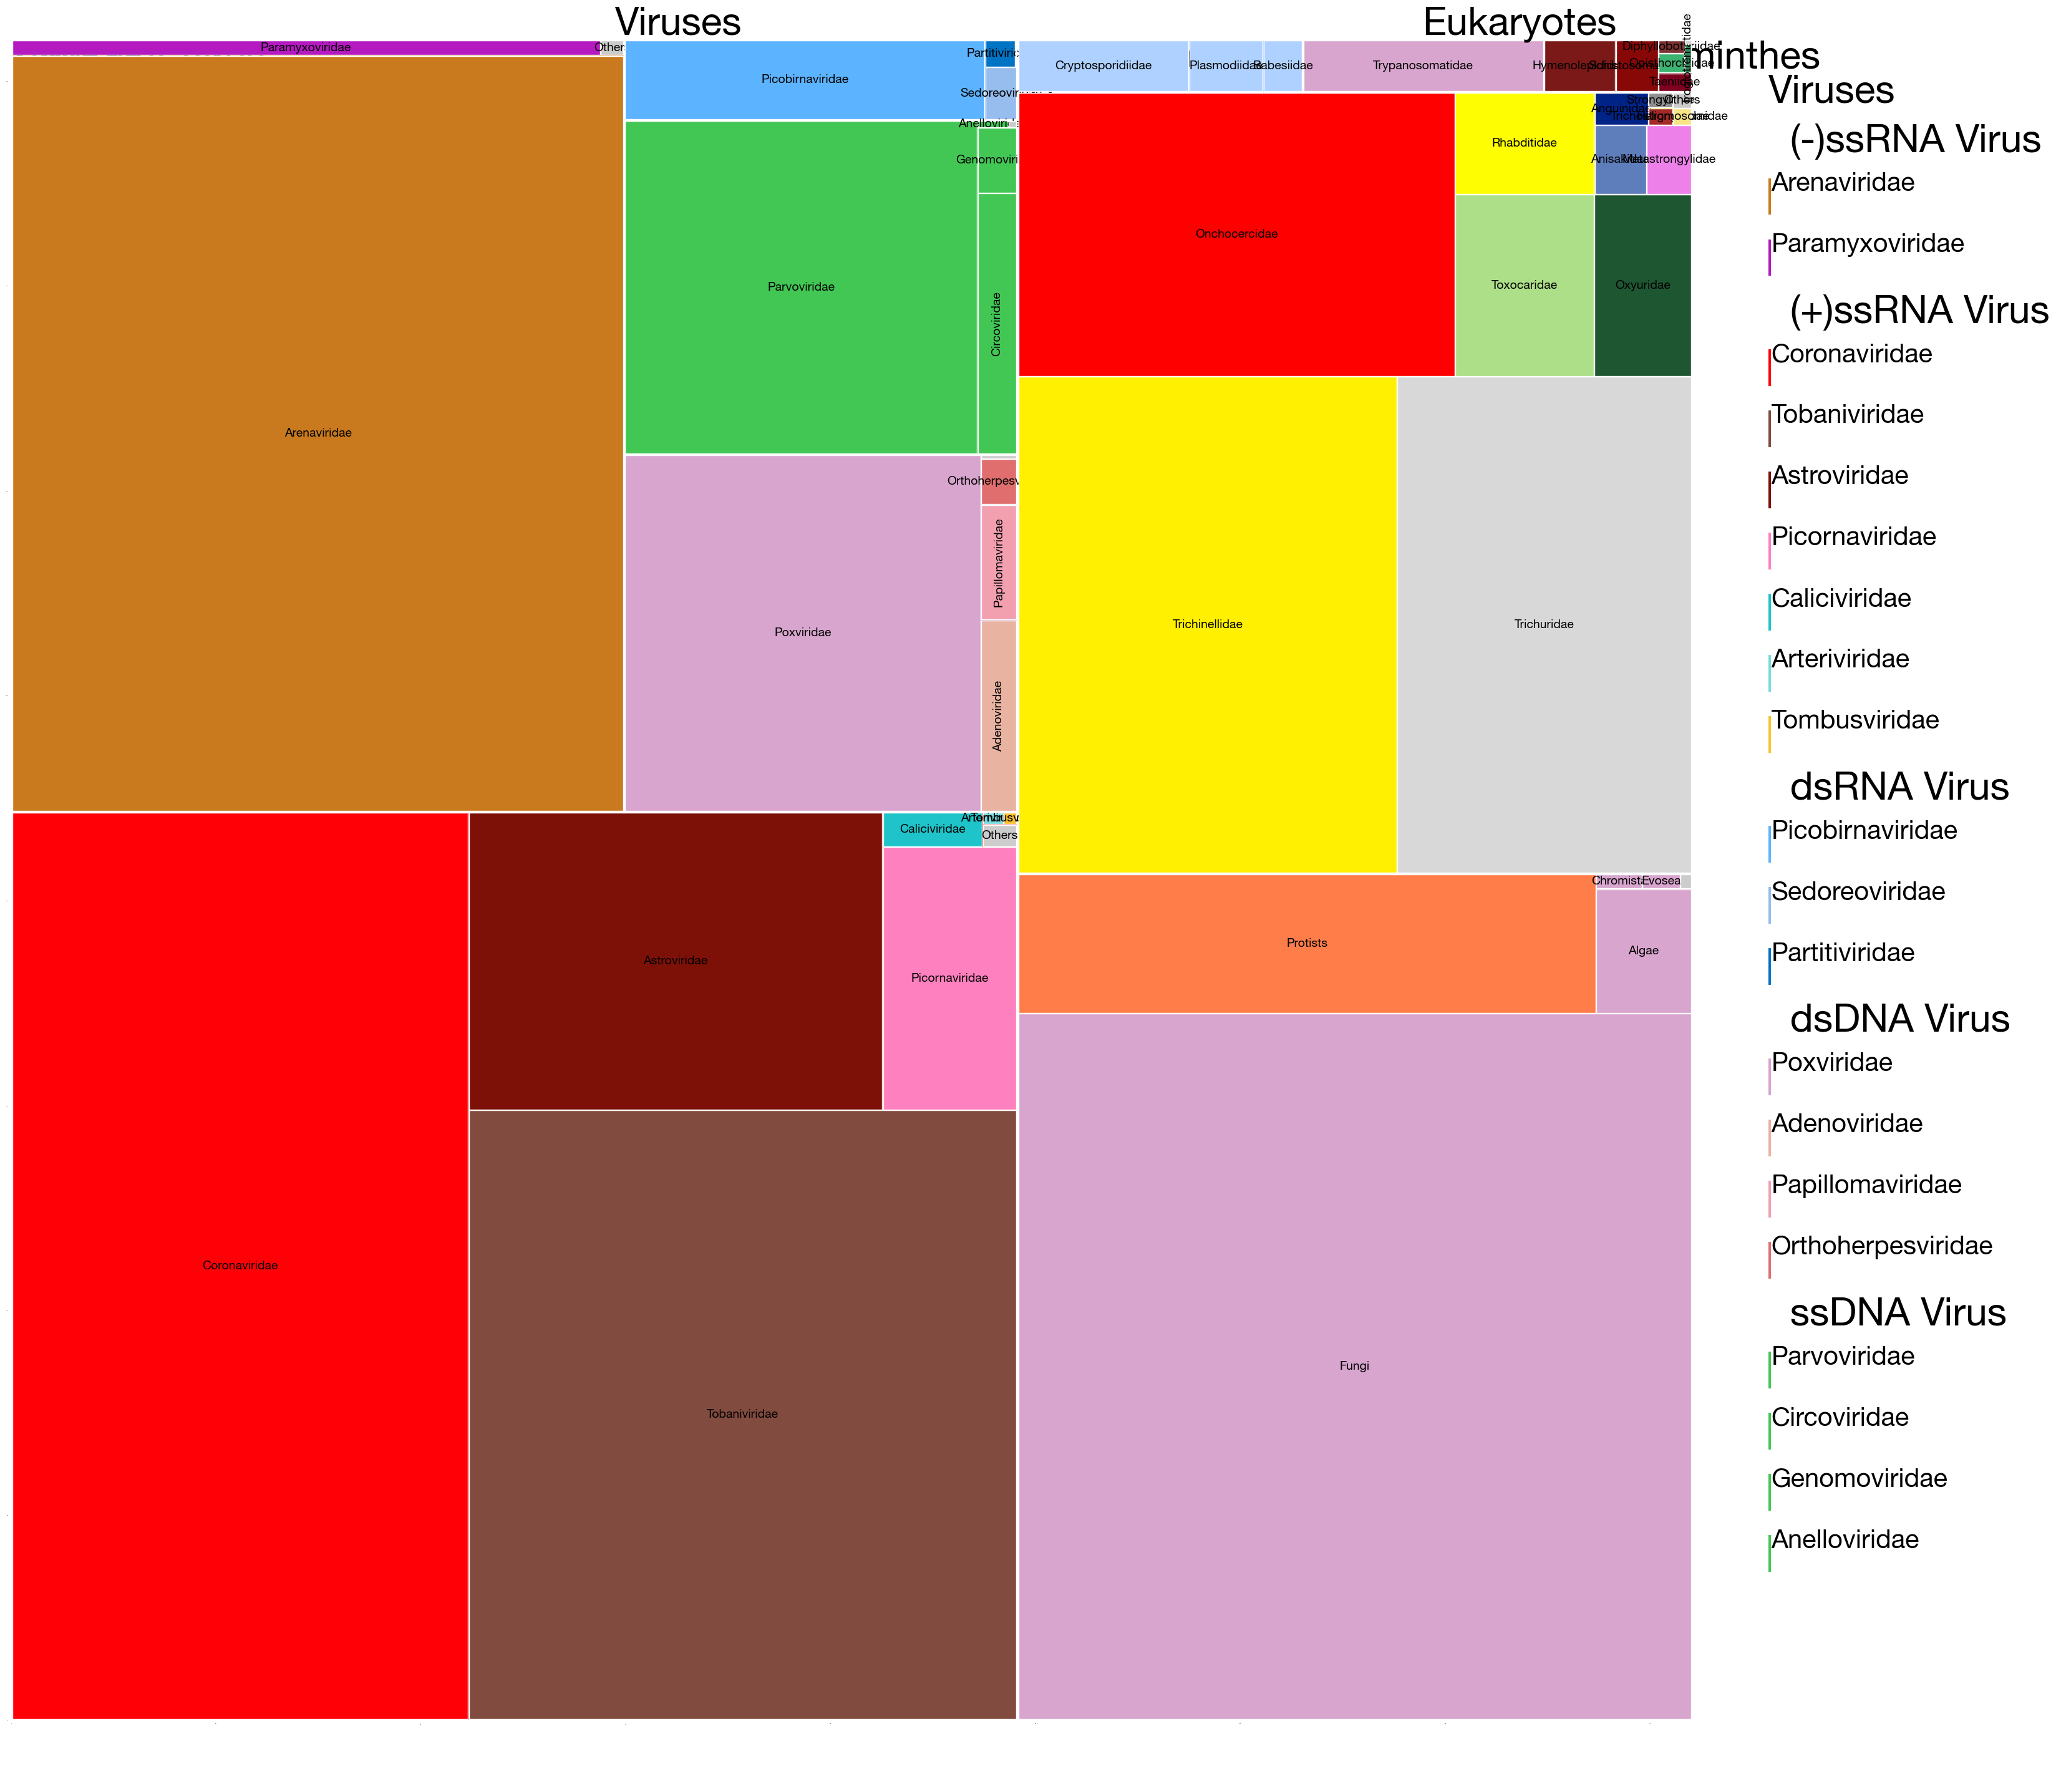

In [111]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec
import numpy as np
import pandas as pd
import squarify
import copy
import re

# -------------------------------
# Style
# -------------------------------
typeface = 'Helvetica Neue'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['font.sans-serif'] = typeface
mpl.rcParams['mathtext.default'] = 'sf'
mpl.rcParams['axes.labelweight'] = 300
mpl.rcParams['font.family'] = typeface
mpl.rcParams['font.size'] = 28
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype']  = 42

# -------------------------------
# Config
# -------------------------------
data_path = '/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Combined_SENZOR_results/Treemap_data.csv'

# How small families are aggregated into "Others"
FAMILY_MIN_READS   = 1_000     # inside each sub-block
SUBBLOCK_MIN_READS = 10_000    # sub-block label threshold

# Order of virus genome types inside "Viruses"
virus_type_order = [
    '(-)ssRNA Virus',
    '(+)ssRNA Virus',
    'dsRNA Virus',
    'dsDNA Virus',
    'ssDNA Virus'
]

# -------------------------------
# Read & clean
# -------------------------------
df = pd.read_csv(data_path)
# strip whitespace everywhere and fix a couple of odd entries
for col in ['family', 'Higher order', 'color']:
    df[col] = df[col].astype(str).str.strip()

# normalize a few variants/typos
replacements = {
    'Platyhelminthes' : 'Platyhelminthes',
    'Platyhelminthes ' : 'Platyhelminthes',
    'Euglenoza' : 'Euglenozoa',
    ' dsRNA Virus' : 'dsRNA Virus',
}
df['Higher order'] = df['Higher order'].replace(replacements)

# helper flags
df['is_virus'] = df['Higher order'].str.contains('Virus', regex=False)

# default color if missing
df['color'] = df['color'].replace({'nan': '#CCCCCC'}).fillna('#CCCCCC')

# -------------------------------
# Build hierarchy with Viruses together
# -------------------------------
def node(name, colour='#FFFFFF', read_count=0):
    return {"taxonomy": name, "attrs": {"read_count": read_count, "colour": colour}, "children": []}

root = node('All')

# ---- Viruses (top-level) ----
vir_df = df[df['is_virus']].copy()
viruses = node('Viruses', '#FFFFFF')        # colour unused for parents

# ensure sub-blocks appear in a consistent order
for vtype in virus_type_order:
    sub = vir_df[vir_df['Higher order'] == vtype]
    if sub.empty:
        continue
    subblock = node(vtype, sub['color'].iloc[0])
    # large families individually, small ones aggregated
    big = sub[sub['Read Count'] >= FAMILY_MIN_READS]
    small = sub[sub['Read Count'] <  FAMILY_MIN_READS]
    for _, r in big.sort_values('Read Count', ascending=False).iterrows():
        subblock['children'].append({"taxonomy": r['family'],
                                     "attrs": {"read_count": int(r['Read Count']),
                                               "colour": r['color']}})
    if not small.empty:
        subblock['children'].append({"taxonomy": "Others",
                                     "attrs": {"read_count": int(small['Read Count'].sum()),
                                               "colour": "#CCCCCC"}})
    viruses['children'].append(subblock)

# ---- Eukaryotes (top-level) ----
nonvir = df[~df['is_virus']].copy()
euks = node('Eukaryotes', '#FFFFFF')

# group all non-viruses by their Higher order (e.g., Nematoda, Platyhelminthes, Apicomplexa, Eukaryota)
for higher, g in nonvir.groupby('Higher order', sort=False):
    subblock = node(higher, g['color'].iloc[0])
    big = g[g['Read Count'] >= FAMILY_MIN_READS]
    small = g[g['Read Count'] <  FAMILY_MIN_READS]
    for _, r in big.sort_values('Read Count', ascending=False).iterrows():
        subblock['children'].append({"taxonomy": r['family'],
                                     "attrs": {"read_count": int(r['Read Count']),
                                               "colour": r['color']}})
    if not small.empty:
        subblock['children'].append({"taxonomy": "Others",
                                     "attrs": {"read_count": int(small['Read Count'].sum()),
                                               "colour": "#CCCCCC"}})
    euks['children'].append(subblock)

# Put viruses first so they occupy one contiguous region
root['children'] = [viruses, euks]

# -------------------------------
# Treemap helpers (unchanged core)
# -------------------------------
def sumValues(node, stat, level=0, order=0):
    node['attrs']['height'] = level
    order += 1
    if node.get('children'):
        node['attrs'][stat] = 0
        level += 1
        for child in node['children']:
            order = sumValues(child, stat, level, order)
            node['attrs'][stat] += child['attrs'][stat]
    else:
        node['attrs'][stat] = node['attrs'].get(stat, 0)
    node['attrs']['order'] = order
    return order

def flatten(node, out=None):
    out = out or []
    out.append(node)
    for ch in node.get('children', []):
        flatten(ch, out)
    return out

def treemapLineages(node, lineage=None):
    lineage = [] if lineage is None else list(lineage)
    if 'taxonomy' in node:
        node['lineage'] = lineage + [node['taxonomy']]
    if node.get('children'):
        lineage.append(node['taxonomy'])
        for ch in node['children']:
            treemapLineages(ch, lineage)
    return lineage

sumValues(root, 'read_count')
treemapLineages(root)
flat = flatten(copy.deepcopy(root))

size = lambda k: k['attrs']['read_count']
edge_length = np.sqrt(size(root))

def computeCoordinates(node, x, y, dx, dy):
    node['attrs'].update({'x': x, 'y': y, 'dx': dx, 'dy': dy})
    if node.get('children'):
        children = sorted(node['children'], key=lambda q: size(q), reverse=True)
        sizes = squarify.normalize_sizes([size(c) for c in children], dx, dy)
        rects = squarify.padded_squarify(sizes, x, y, dx, dy)
        for child, rec in zip(children, rects):
            computeCoordinates(child, rec['x'], rec['y'], rec['dx'], rec['dy'])

def plot(ax, node, parent=None, level=0):
    if all(k in node['attrs'] for k in ['x','y','dx','dy']):
        x, y, w, h = node['attrs']['x'], node['attrs']['y'], node['attrs']['dx'], node['attrs']['dy']
        if w > 0 and h > 0:
            rect = plt.Rectangle((x, y), w, h, facecolor=node['attrs']['colour'],
                                 edgecolor='w', lw=1, alpha=1.0, zorder=level)
            ax.add_patch(rect)

            # label large subblocks and large leaves
            name = node.get('taxonomy', '')
            rotation = 90 if h > (w * 2.0) else 0
            if node.get('children'):
                if size(node) >= SUBBLOCK_MIN_READS and parent is not None:
                    ax.text(x + 0.004*w, y + 0.996*h, name,
                            ha='left', va='top', fontsize=45, weight=500, rotation=rotation)
            else:
                if size(node) >= FAMILY_MIN_READS:
                    ax.text(x + w/2, y + h/2, name,
                            ha='center', va='center', fontsize=14, rotation=rotation)

    for ch in node.get('children', []):
        plot(ax, ch, node, level+1)

# -------------------------------
# Layout & draw
# -------------------------------
fig = plt.figure(figsize=(35, 35), facecolor='w')
gs  = gridspec.GridSpec(1, 1, wspace=0.01, hspace=0.01)
ax  = plt.subplot(gs[0], facecolor='w')

computeCoordinates(root, 0.0, 0.0, edge_length, edge_length)
plot(ax, root, None)

ax.set_xlim(0, edge_length)
ax.set_ylim(0, edge_length)
ax.set_aspect(1)
[ax.spines[loc].set_visible(False) for loc in ax.spines]
ax.tick_params(size=0, labelsize=0)

# Top-level labels so it's obvious viruses are together
for child in root['children']:
    a = child['attrs']
    ax.text(a['x'] + 0.6*a['dx'], a['y'] + 1.02*a['dy'],
            child['taxonomy'], ha='left', va='top', fontsize=45, weight=700)


# -------------------------------
# Grouped legend: headings -> families
# -------------------------------
from matplotlib.patches import Rectangle

# Controls
MAX_PER_GROUP = None      # set an int (e.g., 12) to truncate each group; None shows all
N_COLS         = 4        # columns in the legend panel
ROW_STEP       = 0.035    # vertical spacing per row (in axes fraction)
PANEL_W        = 0.05     # total width fraction of the legend panel (for N_COLS=2)
HEADING_SIZE   = 45
ITEM_SIZE      = 30

# Access our two top-level nodes
viruses_node = root['children'][0]   # 'Viruses'
euks_node    = root['children'][1]   # 'Eukaryotes'

def families_under(subblock):
    """Return leaf children (skip 'Others') sorted by read count desc."""
    fams = []
    for ch in subblock.get('children', []):
        if ch.get('children'):
            continue
        if ch['taxonomy'] == 'Others':
            continue
        fams.append(ch)
    return sorted(fams, key=lambda k: k['attrs']['read_count'], reverse=True)

# Legend panel (to the right of the treemap)
legend_ax = fig.add_axes([.89, 0.08, PANEL_W, 0.80])  # [left, bottom, width, height] in figure coords
legend_ax.axis('off')

# Column bookkeeping
col_width = 1.0 / N_COLS
x0 = 0.85
y  = 0.98
col = 0

def newline():
    """Advance one row; start new column if we run out of vertical space."""
    global y, col, x0
    y -= ROW_STEP
    if y < 0.03:   # start new column
        col += 1
        x0 = col * col_width + 0.05
        y  = 0.98

def add_heading(text):
    global y
    legend_ax.text(x0, y, text, transform=legend_ax.transAxes,
                   ha='left', va='top', fontsize=HEADING_SIZE, weight='bold')
    y -= ROW_STEP * 0.8

def add_item(label, colour):
    global y
    # color swatch
    legend_ax.add_patch(Rectangle((x0, y - ROW_STEP*0.7),
                                  0.02, ROW_STEP*0.6,
                                  transform=legend_ax.transAxes,
                                  facecolor=colour, edgecolor='none'))
    legend_ax.text(x0 + 0.025, y, label, transform=legend_ax.transAxes,
                   ha='left', va='top', fontsize=ITEM_SIZE)
    newline()

# ---------------- Headings & entries ----------------
# 1) Viruses
add_heading("Viruses")
# headings are genome types in your preferred order
v_lookup = {n['taxonomy']: n for n in viruses_node['children']}
for vtype in virus_type_order:
    if vtype not in v_lookup:
        continue
    add_heading(f"  {vtype}")  # indented heading
    fams = families_under(v_lookup[vtype])
    if MAX_PER_GROUP is not None:
        fams = fams[:MAX_PER_GROUP]
    for n in fams:
        add_item(n['taxonomy'], n['attrs']['colour'])

# 2) Eukaryotes
#add_heading("Eukaryotes")
# headings are the Higher order blocks (Nematoda, Platyhelminthes, Apicomplexa, Eukaryota, etc.)
#for block in sorted(euks_node['children'], key=lambda k: k['attrs']['read_count'], reverse=True):
 #   add_heading(f"  {block['taxonomy']}")
 #   fams = families_under(block)
  #  if MAX_PER_GROUP is not None:
  #      fams = fams[:MAX_PER_GROUP]
   # for n in fams:
   #     add_item(n['taxonomy'], n['attrs']['colour'])

#If legend overflows horizontally, either:
#  - increase N_COLS,
#  - increase PANEL_W (e.g., 0.48),
#  - or reduce HEADING_SIZE / ITEM_SIZE / ROW_STEP.


# Optional: save
#plt.savefig('/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Combined_SENZOR_results/treemap_viruses_together.png', dpi=300, bbox_inches='tight')
#plt.savefig('/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Combined_SENZOR_results/treemap_viruses_together.svg', dpi=300, bbox_inches='tight')
plt.show()

In [39]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec
import numpy as np
import pandas as pd
import squarify
import copy

# -------------------------------
# Setup style
# -------------------------------
typeface = 'Helvetica Neue'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['font.sans-serif'] = typeface
mpl.rcParams['mathtext.default'] = 'sf'
mpl.rcParams['axes.labelweight'] = 300
mpl.rcParams['font.family'] = typeface
mpl.rcParams['font.size'] = 45

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# -------------------------------
# Step 1. Read your data and build tree
# -------------------------------
data_path = './Desktop/Virus_fasta/Treemap/SENZOR_Treemap.csv'
df = pd.read_csv(data_path, sep=',')

# Ensure color is a string and strip any extra spaces; fill missing colors with a default
df['color'] = df['color'].fillna("#CCCCCC").astype(str).str.strip()

# Create a root node for the entire treemap
root = {
    "taxonomy": "All",
    "attrs": {
         "read_count": 0,
         "colour": "#FFFFFF"  # not used for plotting
    },
    "children": []
}

# Group the data by "Higher order"
# For each higher order, create a node.
# Within each group, families with read counts >= 1e4 are added as individual nodes,
# and families with read counts < 1e4 are aggregated into a single "Others" node.
for higher, group in df.groupby("Higher order"):
    # Use the first color in the group as the higher order color (adjust if needed)
    higher_color = group['color'].iloc[0]
    higher_node = {
         "taxonomy": higher,
         "attrs": {
              "read_count": 0,
              "colour": higher_color
         },
         "children": []
    }
    
    # Partition families by read count threshold (1e4)
    high_read = group[group["Read Count"] >= 1e3]
    low_read = group[group["Read Count"] < 1e3]
    
    # Add families with high read counts as individual child nodes
    for idx, row in high_read.iterrows():
         child_node = {
              "taxonomy": row["family"],
              "attrs": {
                   "read_count": row["Read Count"],
                   "colour": row["color"]
              }
         }
         higher_node["children"].append(child_node)
    
    # If there are families with low read counts, group them into an "Others" node.
    if not low_read.empty:
         others_count = low_read["Read Count"].sum()
         others_node = {
              "taxonomy": "Others",
              "attrs": {
                   "read_count": others_count,
                   "colour": "#CCCCCC"  # default color for "Others"
              }
         }
         higher_node["children"].append(others_node)
    
    # Append this higher order node to the root.
    root["children"].append(higher_node)

# Use the resulting tree for treemap plotting.
J = root

# -------------------------------
# Step 2. Define treemap functions
# -------------------------------
def sumValues(node, stat, level=None, order=None):
    """
    Recursively sum the 'read_count' values from children and assign extra attributes.
    """
    if level is None:
        level = 0
    if order is None:
        order = 0
    node['attrs']['height'] = level
    order += 1
    if 'children' in node:
        node['attrs'][stat] = 0
        level += 1
        for child in node['children']:
            order = sumValues(child, stat, level, order)
            node['attrs'][stat] += child['attrs'][stat]
    node['attrs']['order'] = order
    return order

def flatten(node, container=None):
    """
    Flatten the tree into a list.
    """
    if container is None:
        container = []
    container.append(node)
    if 'children' in node:
        for child in node['children']:
            flatten(child, container)
    return container

def treemapLineages(node, lineage=None):
    """
    Optionally assign a 'lineage' to each node.
    """
    if lineage is None:
        lineage = []
    lin = list(lineage)
    if 'taxonomy' in node:
        node['lineage'] = lin + [node['taxonomy']]
    if 'children' in node:
        if 'taxonomy' in node:
            lin.append(node['taxonomy'])
        for child in node['children']:
            treemapLineages(child, lin)
    return lineage

# Sum read counts upward and set extra attributes.
sumValues(J, 'read_count')
treemapLineages(J)
flatJ = flatten(copy.deepcopy(J))
print("Total branches:", len(flatJ))
print("Total read count at root:", flatJ[0]['attrs']['read_count'])

# Define a size function (area is proportional to read count)
size = lambda k: k['attrs']['read_count']
edge_length = np.sqrt(size(J))
print("Edge length:", edge_length)

def computeCoordinates(node, x, y, dx, dy):
    """
    Recursively compute treemap coordinates using squarify.
    """
    node['attrs']['x'] = x
    node['attrs']['y'] = y
    node['attrs']['dx'] = dx
    node['attrs']['dy'] = dy

    if 'children' in node:
        # Sort children by area (largest first)
        children = sorted(node['children'], key=lambda q: size(q), reverse=True)
        children_values = [size(child) for child in children]
        sizes = squarify.normalize_sizes(children_values, dx, dy)
        rects = squarify.padded_squarify(sizes, x, y, dx, dy)
        for child, rec in zip(children, rects):
            computeCoordinates(child, rec['x'], rec['y'], rec['dx'], rec['dy'])

def plot(ax, node, parent=None, level=0):
    """
    Recursively plot each node as a rectangle.
    """
    if 'x' in node['attrs']:
        x = node['attrs']['x']
        y = node['attrs']['y']
        w = node['attrs']['dx']
        h = node['attrs']['dy']
        if w == 0 or h == 0:
            print(f"Box {node.get('taxonomy','')} has zero width or height: {w}, {h}")
        else:
            c = node['attrs']['colour']
            lw = 1
            rect = plt.Rectangle((x, y), w, h, facecolor=c, edgecolor='w',
                                 alpha=1.0, lw=lw, zorder=level)
            rotation = 0
            if h > (w * 2):
                rotation = 90
            # Label only nodes that are large enough.
            if 'taxonomy' in node and size(node) > 10000.0:
                name = node['taxonomy']
                if 'children' in node and (parent is None or name != parent.get('taxonomy', '')):
                    if level < 5:
                        ax.text(x + w - 0.0015, y + 0.0015, name,
                                ha='right', va='bottom', size=22-level,
                                zorder=10000, rotation=rotation)
                    else:
                        ax.text(x + 0.0015, y + h - 0.0015, name,
                                ha='left', va='top', size=25-level,
                                zorder=level+10, rotation=rotation)
                elif 'children' not in node:
                    ax.text(x + w/2, y + h/2, name, ha='center', va='center',
                            size=35, zorder=level+10, rotation=rotation)
            ax.add_patch(rect)
    if 'children' in node:
        for child in node['children']:
            plot(ax, child, node, level+1)

# -------------------------------
# Step 3. Compute coordinates and plot the treemap
# -------------------------------
fig = plt.figure(figsize=(60, 40), facecolor='w')
gs = gridspec.GridSpec(1, 1, wspace=0.01, hspace=0.01)
ax = plt.subplot(gs[0], facecolor='w')

computeCoordinates(J, 0.0, 0.0, edge_length, edge_length)
plot(ax, J, None)

# Fix the axis limits to our computed space
ax.set_xlim(0, edge_length)
ax.set_ylim(0, edge_length)
ax.set_aspect(1)

# -------------------------------
# Step 4. (Optional) Add a legend
# -------------------------------
if edge_length > 3000.0:
    unit = 100.0  # legend square unit
    legend_label = f'{int(unit)} reads'
    X = edge_length + 100
else:
    unit = 4.0
    legend_label = f'{int(unit)} contigs'
    X = -7

ax.text(X + unit * 1.1, unit/2, legend_label, size=50, va='center', ha='left')
legend = plt.Rectangle((X, 0.0), unit, unit, lw=2, facecolor='k',
                       edgecolor='none', zorder=100, clip_on=False)
ax.add_patch(legend)

# Create legend entries for each unique color in our flattened tree.
branchesByLevel = sorted(flatJ[2:], key=lambda k: (-k['attrs']['order'], k['attrs']['height']))
colours = {}
for b in branchesByLevel:
    col = b['attrs']['colour']
    if col not in colours:
        y = edge_length * 0.1 + len(colours) * edge_length / 25.0
        ax.add_patch(plt.Rectangle((X, y - unit), unit, unit, lw=2, facecolor=col,
                                   edgecolor='none', zorder=1000, clip_on=False))
        ax.text(X + unit * 1.1, y - unit/2.0, b.get('taxonomy', ''), size=50, ha='left', va='center')
        colours[col] = b.get('taxonomy', '')


from matplotlib.patches import Patch

# --- Legend settings ---
LEGEND_FAMILIES = False   # set True to list every family (long!)
LEGEND_TITLE    = "Groups"
LEGEND_FONTSIZE = 26
LEGEND_TITLE_SIZE = 28
LEGEND_NCOLS    = 1       # bump to 2 if the list is very long

def gather_legend_items(root, families=False):
    items = []
    viruses_node = root['children'][0]   # we appended [viruses, euks] in this order
    euks_node    = root['children'][1]

    if families:
        # collect all leaves (skip "Others"), sorted by abundance
        def leaves(n):
            out = []
            for ch in n.get('children', []):
                if ch.get('children'):
                    out.extend(leaves(ch))
                else:
                    if ch['taxonomy'] != 'Others':
                        out.append(ch)
            return out

        v_leaves = sorted(leaves(viruses_node), key=lambda k: k['attrs']['read_count'], reverse=True)
        e_leaves = sorted(leaves(euks_node),    key=lambda k: k['attrs']['read_count'], reverse=True)
        for n in v_leaves + e_leaves:
            items.append((n['taxonomy'], n['attrs']['colour']))
    else:
        # subblocks only: virus genome types in your predefined order
        v_lookup = {c['taxonomy']: c for c in viruses_node['children']}
        for vtype in virus_type_order:
            if vtype in v_lookup:
                n = v_lookup[vtype]
                items.append((n['taxonomy'], n['attrs']['colour']))

        # then eukaryote higher orders by size
        for n in sorted(euks_node['children'], key=lambda k: k['attrs']['read_count'], reverse=True):
            items.append((n['taxonomy'], n['attrs']['colour']))

    return items

legend_items = gather_legend_items(root, families=LEGEND_FAMILIES)
handles = [Patch(facecolor=c, edgecolor='none', label=lab) for lab, c in legend_items]

# place legend to the right; bbox_inches='tight' will include it on save
lgd = fig.legend(handles=handles,
                 loc='upper left', bbox_to_anchor=(1.01, 1.0),
                 frameon=False, borderaxespad=0,
                 ncol=LEGEND_NCOLS, title=LEGEND_TITLE,
                 prop={'size': LEGEND_FONTSIZE})
lgd.set_title(LEGEND_TITLE, prop={'size': LEGEND_TITLE_SIZE})

# (optional) if legend runs off the page, either reduce font size,
# set LEGEND_NCOLS=2, or make the figure a bit wider.


[ax.spines[loc].set_visible(False) for loc in ax.spines]
ax.tick_params(size=0, labelsize=0)

plt.savefig('./Desktop/Virus_fasta/Treemap/1majorhigher_order_treemap_Vireuk.pdf', dpi=300, bbox_inches='tight')
plt.savefig('./Desktop/Virus_fasta/Treemap/1majorhigher_order_treemap_Vireuk.png', dpi=300, bbox_inches='tight')
plt.savefig('./Desktop/Virus_fasta/Treemap/1majorhigher_order_treemap_Vireuk.svg', dpi=300, bbox_inches='tight')

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './Desktop/Virus_fasta/Treemap/SENZOR_Treemap.csv'

Total branches: 66
Total read count at root: 16826582
Edge length: 4102.021696675921


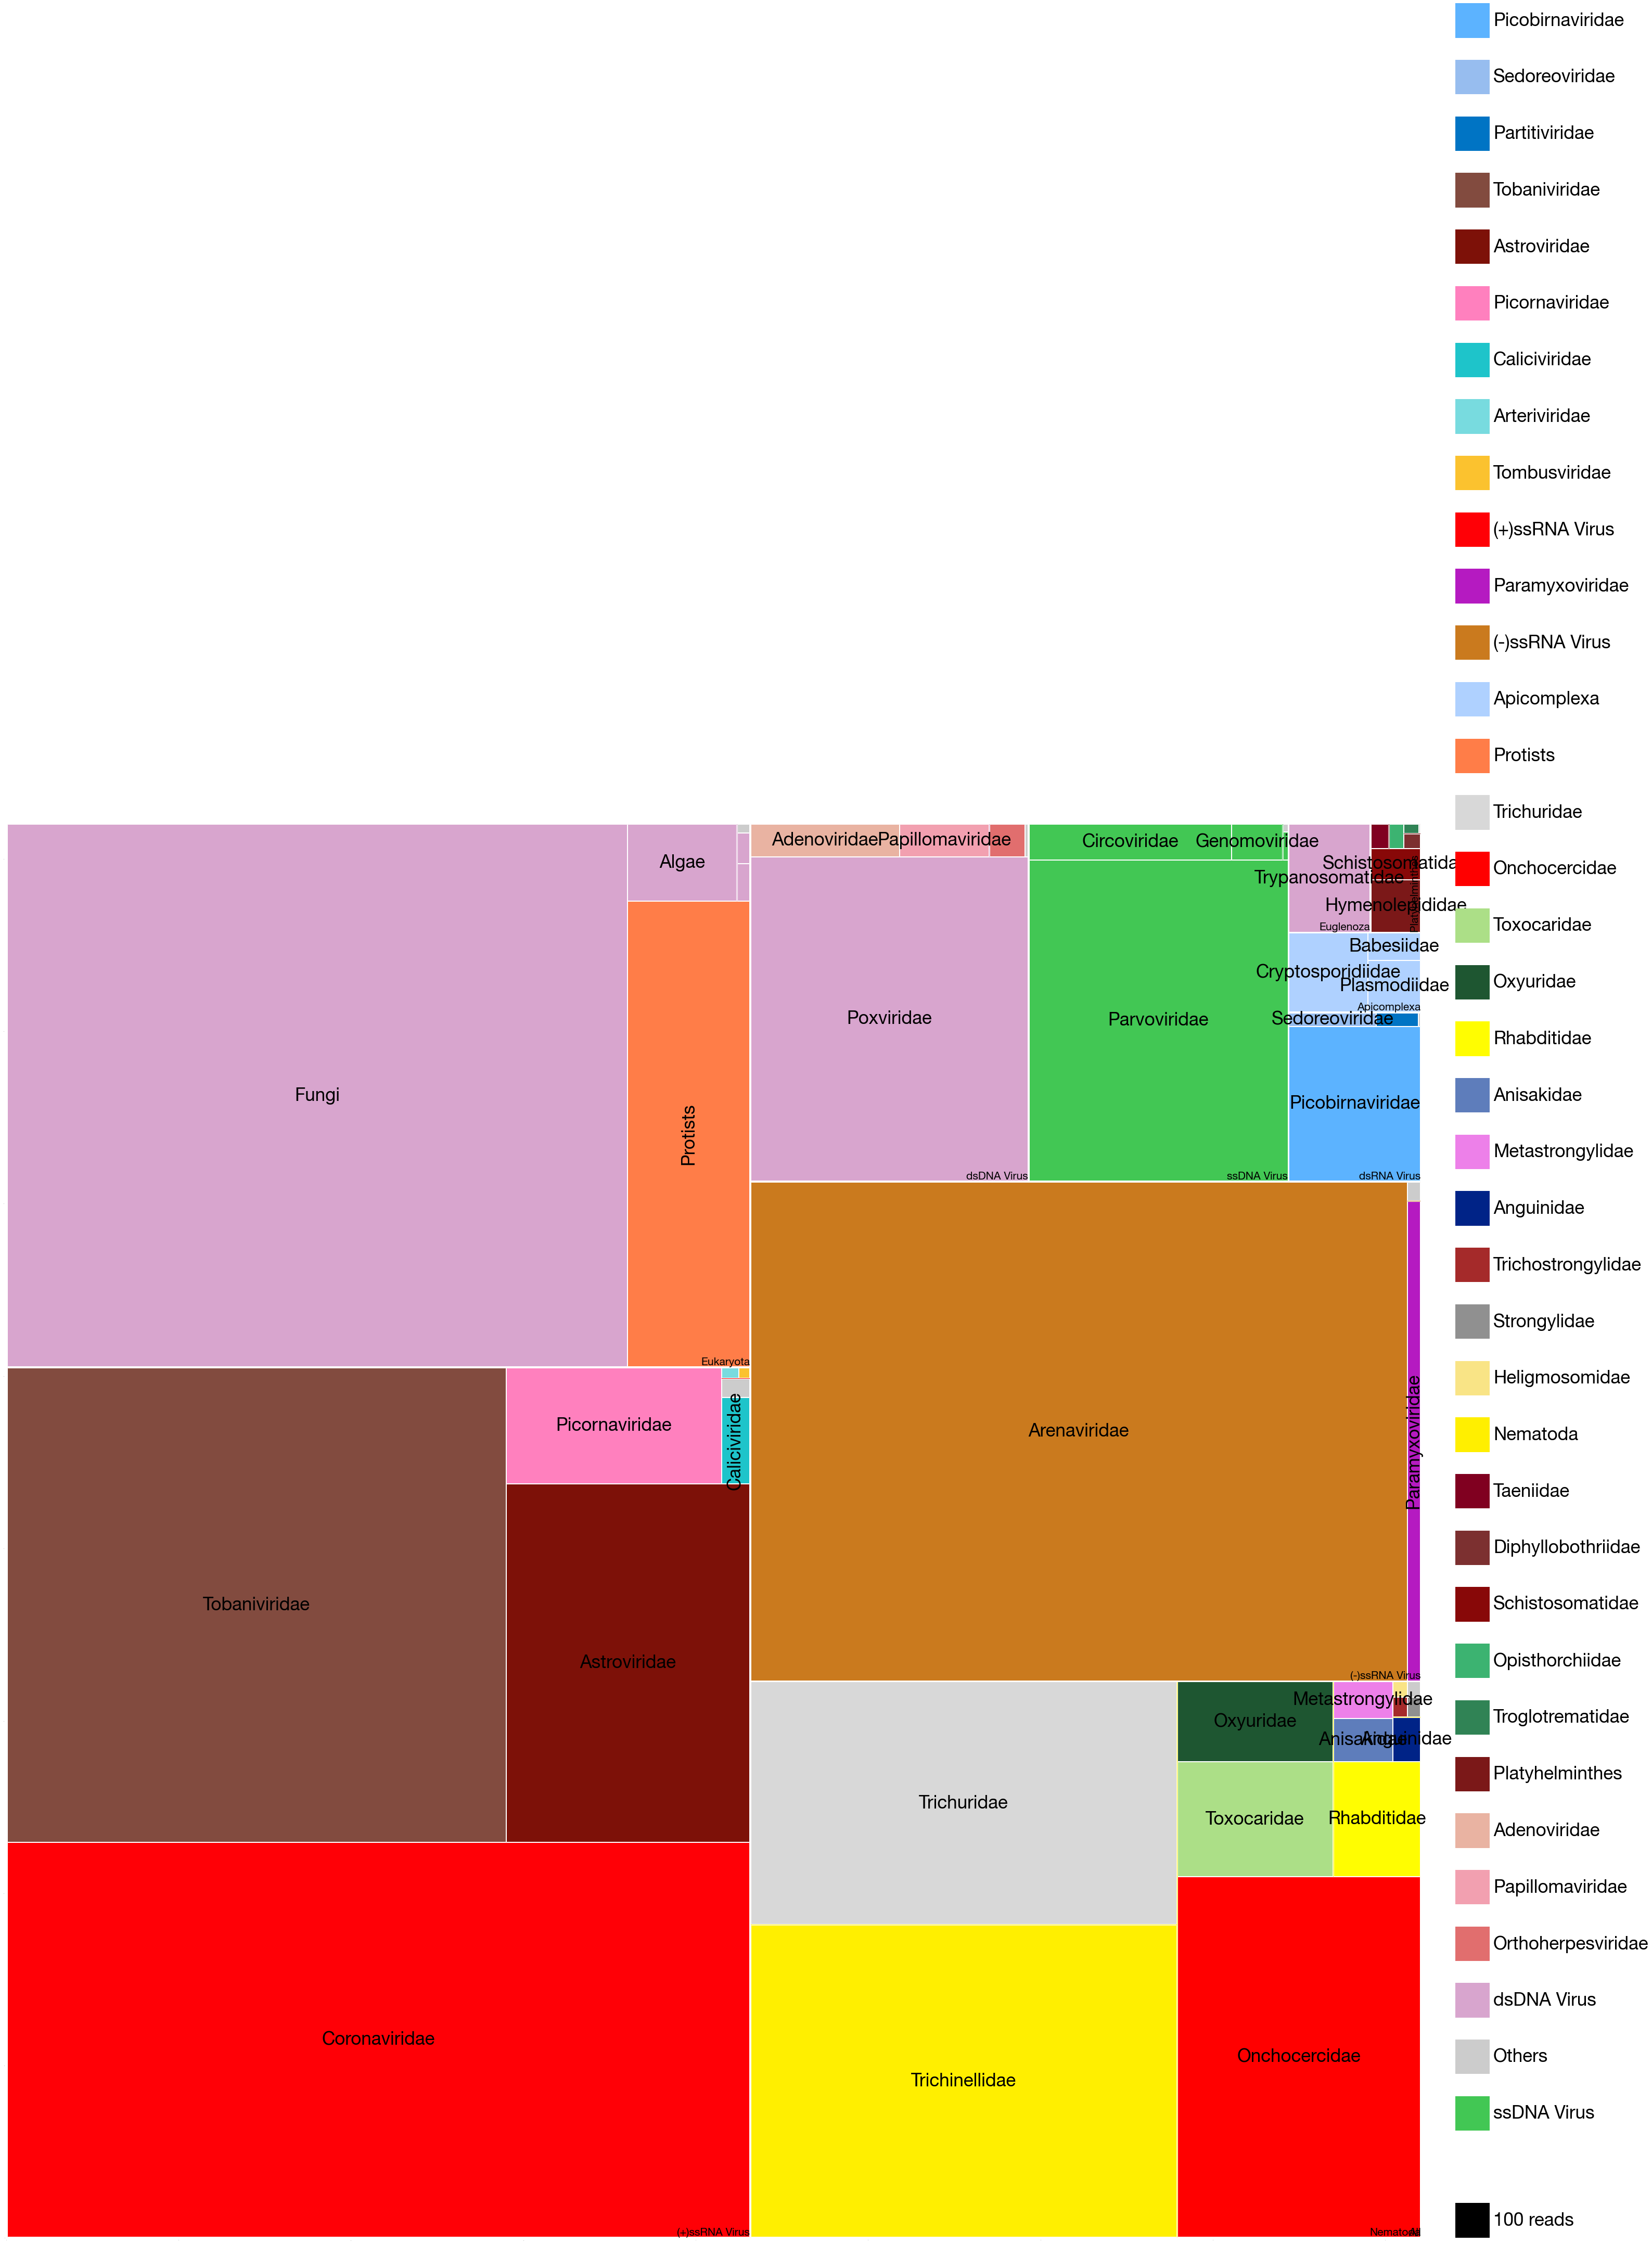

In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec
import numpy as np
import pandas as pd
import squarify
import copy

# -------------------------------
# Setup style
# -------------------------------
typeface = 'Helvetica Neue'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['font.sans-serif'] = typeface
mpl.rcParams['mathtext.default'] = 'sf'
mpl.rcParams['axes.labelweight'] = 300
mpl.rcParams['font.family'] = typeface
mpl.rcParams['font.size'] = 500

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# -------------------------------
# Step 1. Read your data and build tree
# -------------------------------
data_path = '/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Combined_SENZOR_results/Treemap_data.csv'
df = pd.read_csv(data_path, sep=',')

# Ensure color is a string and strip any extra spaces; fill missing colors with a default
df['color'] = df['color'].fillna("#CCCCCC").astype(str).str.strip()

# Create a root node for the entire treemap
root = {
    "taxonomy": "All",
    "attrs": {
         "read_count": 0,
         "colour": "#FFFFFF"  # not used for plotting
    },
    "children": []
}

# Group the data by "Higher order"
# For each higher order, create a node.
# Within each group, families with read counts >= 1e4 are added as individual nodes,
# and families with read counts < 1e4 are aggregated into a single "Others" node.
for higher, group in df.groupby("Higher order"):
    # Use the first color in the group as the higher order color (adjust if needed)
    higher_color = group['color'].iloc[0]
    higher_node = {
         "taxonomy": higher,
         "attrs": {
              "read_count": 0,
              "colour": higher_color
         },
         "children": []
    }
    
    # Partition families by read count threshold (1e4)
    high_read = group[group["Read Count"] >= 1e3]
    low_read = group[group["Read Count"] < 1e3]
    
    # Add families with high read counts as individual child nodes
    for idx, row in high_read.iterrows():
         child_node = {
              "taxonomy": row["family"],
              "attrs": {
                   "read_count": row["Read Count"],
                   "colour": row["color"]
              }
         }
         higher_node["children"].append(child_node)
    
    # If there are families with low read counts, group them into an "Others" node.
    if not low_read.empty:
         others_count = low_read["Read Count"].sum()
         others_node = {
              "taxonomy": "Others",
              "attrs": {
                   "read_count": others_count,
                   "colour": "#CCCCCC"  # default color for "Others"
              }
         }
         higher_node["children"].append(others_node)
    
    # Append this higher order node to the root.
    root["children"].append(higher_node)

# Use the resulting tree for treemap plotting.
J = root

# -------------------------------
# Step 2. Define treemap functions
# -------------------------------
def sumValues(node, stat, level=None, order=None):
    """
    Recursively sum the 'read_count' values from children and assign extra attributes.
    """
    if level is None:
        level = 0
    if order is None:
        order = 0
    node['attrs']['height'] = level
    order += 1
    if 'children' in node:
        node['attrs'][stat] = 0
        level += 1
        for child in node['children']:
            order = sumValues(child, stat, level, order)
            node['attrs'][stat] += child['attrs'][stat]
    node['attrs']['order'] = order
    return order

def flatten(node, container=None):
    """
    Flatten the tree into a list.
    """
    if container is None:
        container = []
    container.append(node)
    if 'children' in node:
        for child in node['children']:
            flatten(child, container)
    return container

def treemapLineages(node, lineage=None):
    """
    Optionally assign a 'lineage' to each node.
    """
    if lineage is None:
        lineage = []
    lin = list(lineage)
    if 'taxonomy' in node:
        node['lineage'] = lin + [node['taxonomy']]
    if 'children' in node:
        if 'taxonomy' in node:
            lin.append(node['taxonomy'])
        for child in node['children']:
            treemapLineages(child, lin)
    return lineage

# Sum read counts upward and set extra attributes.
sumValues(J, 'read_count')
treemapLineages(J)
flatJ = flatten(copy.deepcopy(J))
print("Total branches:", len(flatJ))
print("Total read count at root:", flatJ[0]['attrs']['read_count'])

# Define a size function (area is proportional to read count)
size = lambda k: k['attrs']['read_count']
edge_length = np.sqrt(size(J))
print("Edge length:", edge_length)

def computeCoordinates(node, x, y, dx, dy):
    """
    Recursively compute treemap coordinates using squarify.
    """
    node['attrs']['x'] = x
    node['attrs']['y'] = y
    node['attrs']['dx'] = dx
    node['attrs']['dy'] = dy

    if 'children' in node:
        # Sort children by area (largest first)
        children = sorted(node['children'], key=lambda q: size(q), reverse=True)
        children_values = [size(child) for child in children]
        sizes = squarify.normalize_sizes(children_values, dx, dy)
        rects = squarify.padded_squarify(sizes, x, y, dx, dy)
        for child, rec in zip(children, rects):
            computeCoordinates(child, rec['x'], rec['y'], rec['dx'], rec['dy'])

def plot(ax, node, parent=None, level=0):
    """
    Recursively plot each node as a rectangle.
    """
    if 'x' in node['attrs']:
        x = node['attrs']['x']
        y = node['attrs']['y']
        w = node['attrs']['dx']
        h = node['attrs']['dy']
        if w == 0 or h == 0:
            print(f"Box {node.get('taxonomy','')} has zero width or height: {w}, {h}")
        else:
            c = node['attrs']['colour']
            lw = 1
            rect = plt.Rectangle((x, y), w, h, facecolor=c, edgecolor='w',
                                 alpha=1.0, lw=lw, zorder=level)
            rotation = 0
            if h > (w * 2):
                rotation = 90
            # Label only nodes that are large enough.
            if 'taxonomy' in node and size(node) > 10000.0:
                name = node['taxonomy']
                if 'children' in node and (parent is None or name != parent.get('taxonomy', '')):
                    if level < 5:
                        ax.text(x + w - 0.0015, y + 0.0015, name,
                                ha='right', va='bottom', size=22-level,
                                zorder=10000, rotation=rotation)
                    else:
                        ax.text(x + 0.0015, y + h - 0.0015, name,
                                ha='left', va='top', size=25-level,
                                zorder=level+10, rotation=rotation)
                elif 'children' not in node:
                    ax.text(x + w/2, y + h/2, name, ha='center', va='center',
                            size=35, zorder=level+10, rotation=rotation)
            ax.add_patch(rect)
    if 'children' in node:
        for child in node['children']:
            plot(ax, child, node, level+1)

# -------------------------------
# Step 3. Compute coordinates and plot the treemap
# -------------------------------
fig = plt.figure(figsize=(100, 50), facecolor='w')
gs = gridspec.GridSpec(1, 1, wspace=0.01, hspace=0.01)
ax = plt.subplot(gs[0], facecolor='w')

computeCoordinates(J, 0.0, 0.0, edge_length, edge_length)
plot(ax, J, None)

# Fix the axis limits to our computed space
ax.set_xlim(0, edge_length)
ax.set_ylim(0, edge_length)
ax.set_aspect(1)

# -------------------------------
# Step 4. (Optional) Add a legend
# -------------------------------
if edge_length > 3000.0:
    unit = 100.0  # legend square unit
    legend_label = f'{int(unit)} reads'
    X = edge_length + 100
else:
    unit = 4.0
    legend_label = f'{int(unit)} contigs'
    X = -7

ax.text(X + unit * 1.1, unit/2, legend_label, size=35, va='center', ha='left')
legend = plt.Rectangle((X, 0.0), unit, unit, lw=2, facecolor='k',
                       edgecolor='none', zorder=100, clip_on=False)
ax.add_patch(legend)

# Create legend entries for each unique color in our flattened tree.
branchesByLevel = sorted(flatJ[2:], key=lambda k: (-k['attrs']['order'], k['attrs']['height']))
colours = {}
for b in branchesByLevel:
    col = b['attrs']['colour']
    if col not in colours:
        y = edge_length * 0.1 + len(colours) * edge_length / 25.0
        ax.add_patch(plt.Rectangle((X, y - unit), unit, unit, lw=2, facecolor=col,
                                   edgecolor='none', zorder=1000, clip_on=False))
        ax.text(X + unit * 1.1, y - unit/2.0, b.get('taxonomy', ''), size=35, ha='left', va='center')
        colours[col] = b.get('taxonomy', '')

[ax.spines[loc].set_visible(False) for loc in ax.spines]
ax.tick_params(size=0, labelsize=0)


#plt.savefig('./Desktop/Virus_fasta/Treemap/1majorhigher_order_treemap_Vireuk.pdf', dpi=300, bbox_inches='tight')
#plt.savefig('./Desktop/Virus_fasta/Treemap/today_treemap_Vireuk.png', dpi=300, bbox_inches='tight')
#plt.savefig('./Desktop/Virus_fasta/Treemap/1majorhigher_order_treemap_complete.svg', dpi=300, bbox_inches='tight')

plt.show()

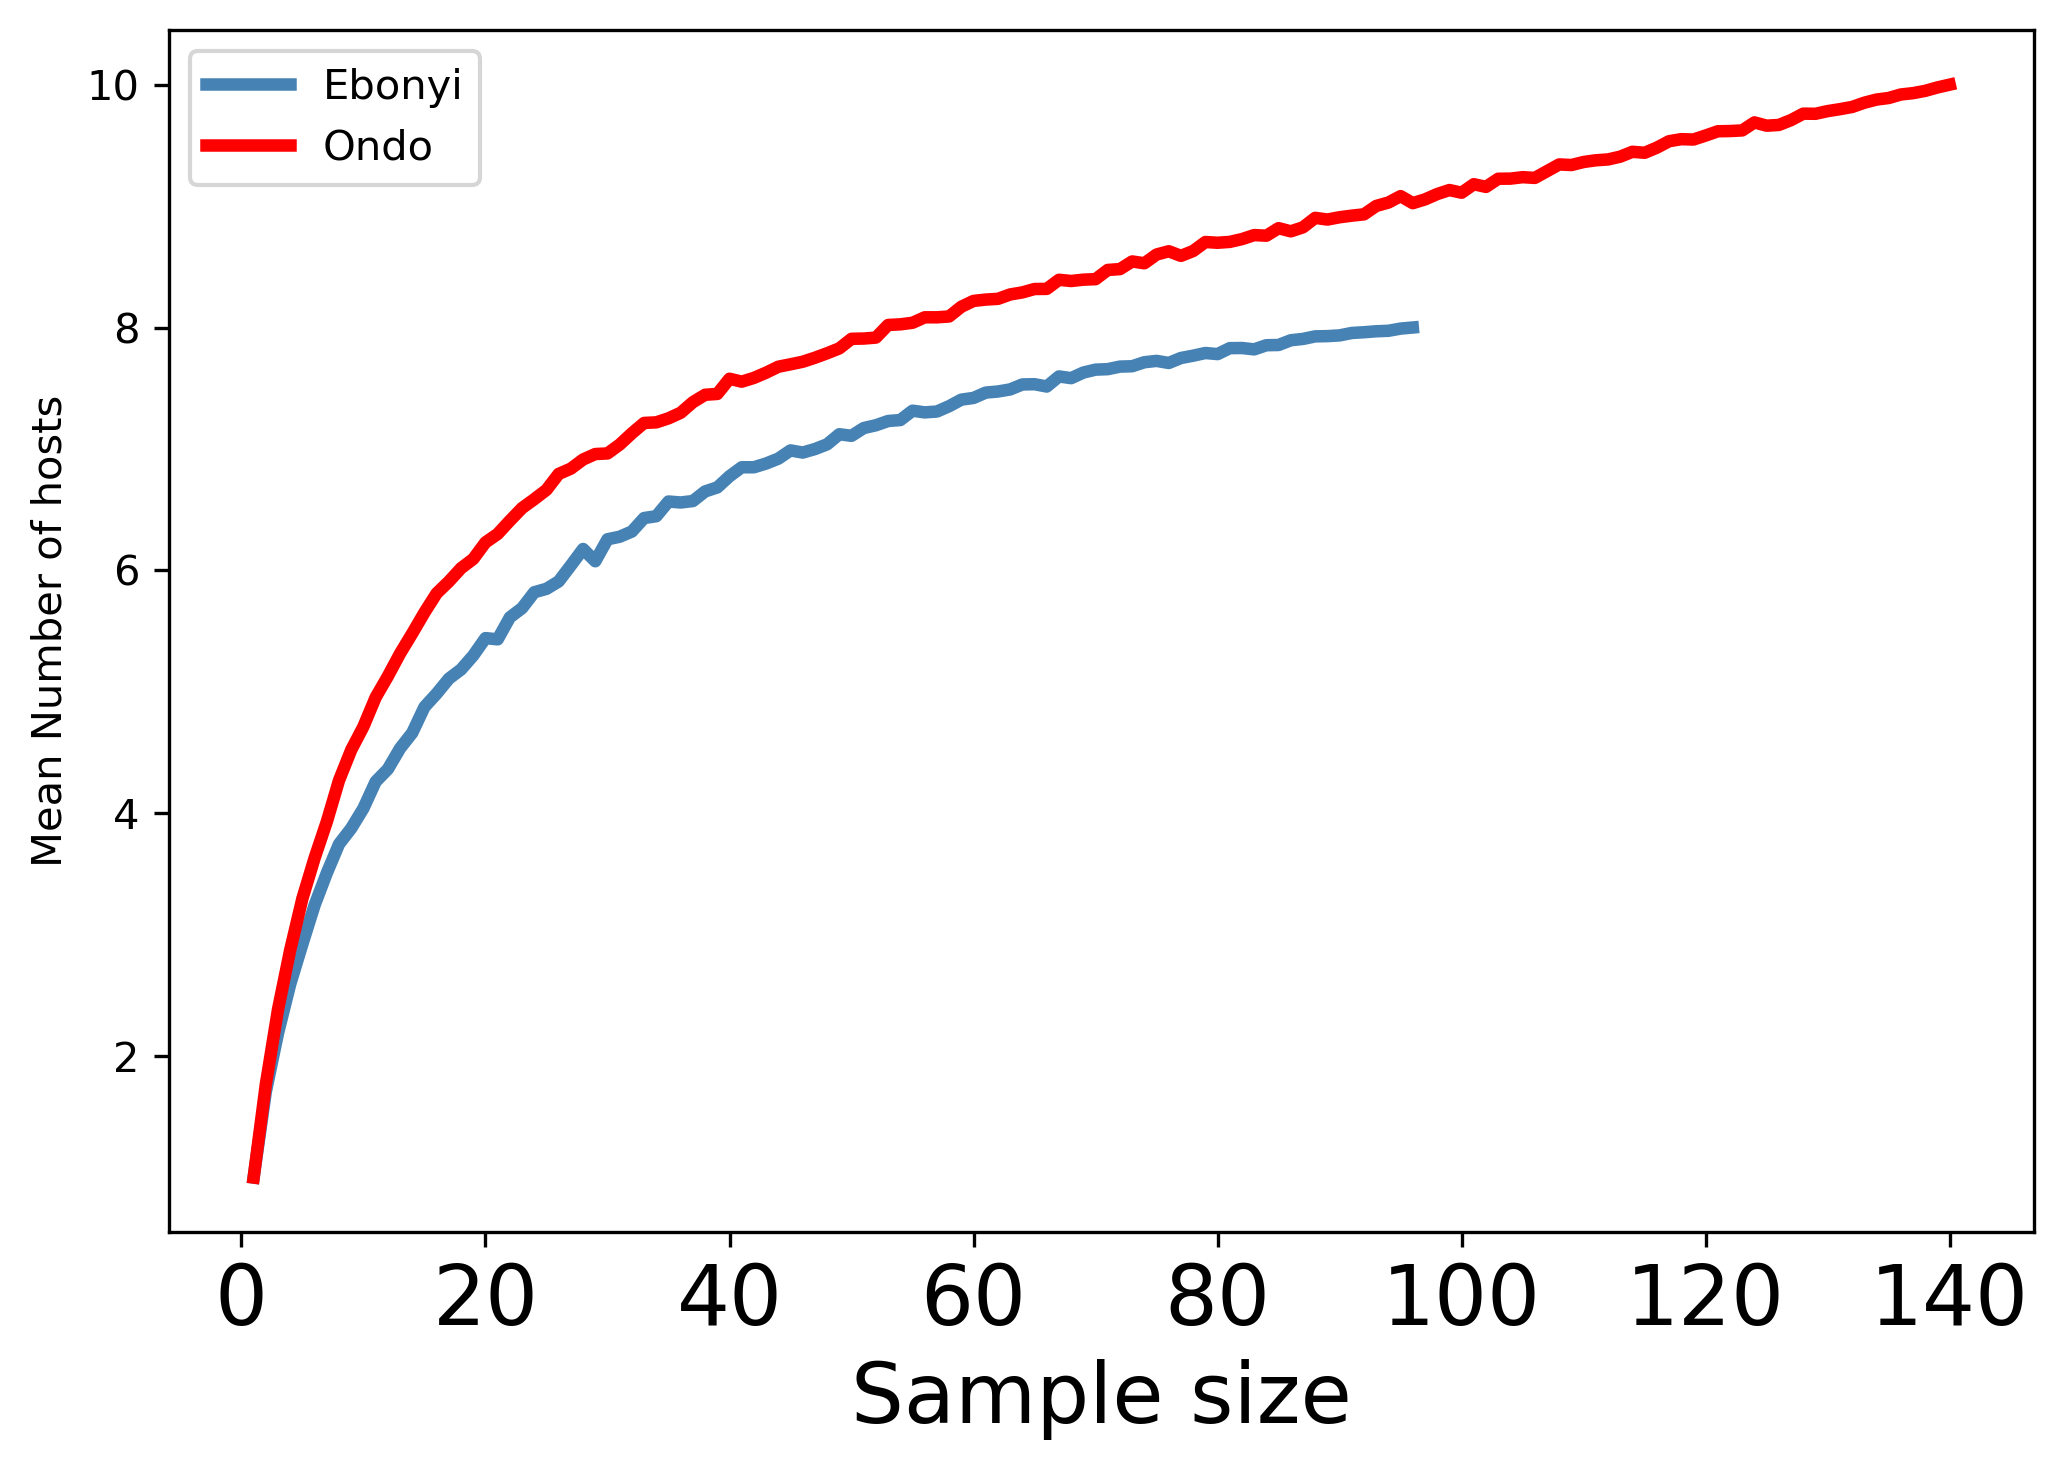

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------
# 1. Define Your Data
# ------------------------------
df = pd.DataFrame({
    "Bat":      [0, 10],
    "Cat":      [1,  1],
    "Chicken":  [3,  1],
    "Dog":      [9,  22],
    "Egret":    [0,  10],
    "Goat":     [24, 22],
    "Lizard":   [2,  1],
    "Pig":      [4,  0],
    "Rodent":   [46, 59],
    "Sheep":    [7,  4],
    "Squirrel": [0, 10]
}, index=["Ebonyi", "Ondo"]).fillna(0)

# (Optional) Set a seed for reproducibility
# random.seed(42)

# ------------------------------
# 2. Rarefaction Function
# ------------------------------
def compute_rarefaction_curve(count_series, n_reps=1000, max_samples=None):
    """
    count_series: pandas Series or dict of host: count
    n_reps: number of replicate draws at each sample size
    max_samples: maximum number of individuals to sample (defaults to total)
    Returns:
       sample_sizes: list of sample sizes from 1..max_samples
       mean_richness: average number of unique hosts for each sample size
    """
    # Create a list of individuals by repeating each host count times
    individuals = []
    for host, c in count_series.items():
        individuals.extend([host] * int(c))
    
    total_individuals = len(individuals)
    if max_samples is None or max_samples > total_individuals:
        max_samples = total_individuals

    sample_sizes = range(1, max_samples + 1)
    mean_richness = []

    # For each sample size, do multiple random draws and measure richness
    for s in sample_sizes:
        replicate_richness = []
        for _ in range(n_reps):
            # Randomly sample s individuals (without replacement)
            subset = random.sample(individuals, s)
            # Count how many unique hosts appear
            replicate_richness.append(len(set(subset)))
        # Average richness across replicates
        mean_richness.append(np.mean(replicate_richness))

    return sample_sizes, mean_richness

# ------------------------------
# 3. Compute Rarefaction for Ebonyi & Ondo
# ------------------------------
ebonyi_counts = df.loc["Ebonyi"]
ondo_counts   = df.loc["Ondo"]

ebonyi_x, ebonyi_y = compute_rarefaction_curve(ebonyi_counts, n_reps=1000)
ondo_x, ondo_y     = compute_rarefaction_curve(ondo_counts, n_reps=1000)

# ------------------------------
# 4. Plot the Rarefaction Curves (Thicker Lines)
# ------------------------------
plt.figure(figsize=(7, 5), dpi=300)

# Increase line thickness with 'linewidth' or 'lw'
plt.plot(ebonyi_x, ebonyi_y, label="Ebonyi", color="Steelblue", linewidth=3)
plt.plot(ondo_x, ondo_y,     label="Ondo",   color="red",       linewidth=3)

plt.xlabel("Sample size", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Mean Number of hosts")
plt.legend()
plt.tight_layout()
plt.show()
